In [1]:
pip install timesfm[torch]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.9/819.9 kB 14.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 73.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 MB 15.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 92.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/21.2 MB 65.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

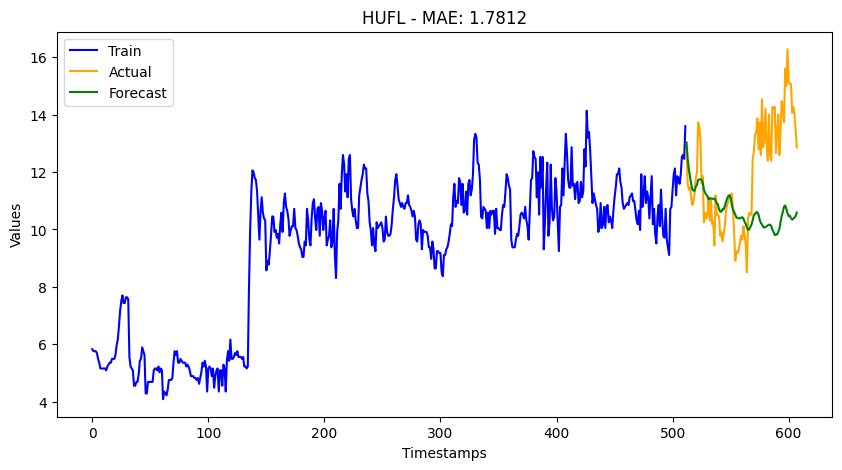

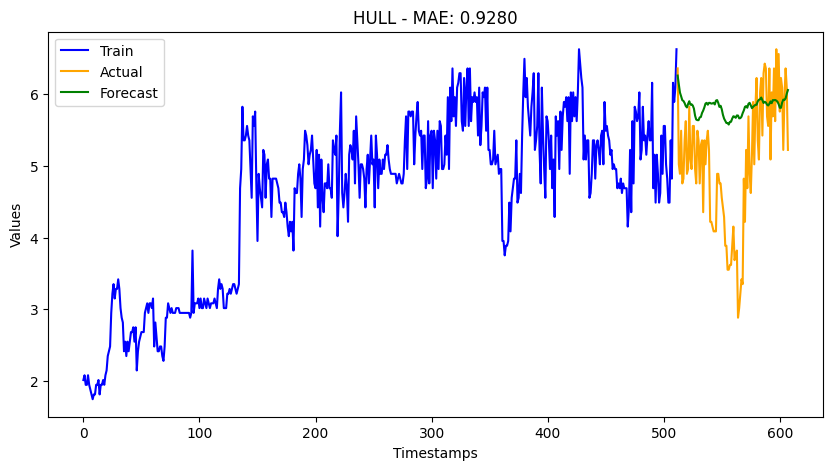

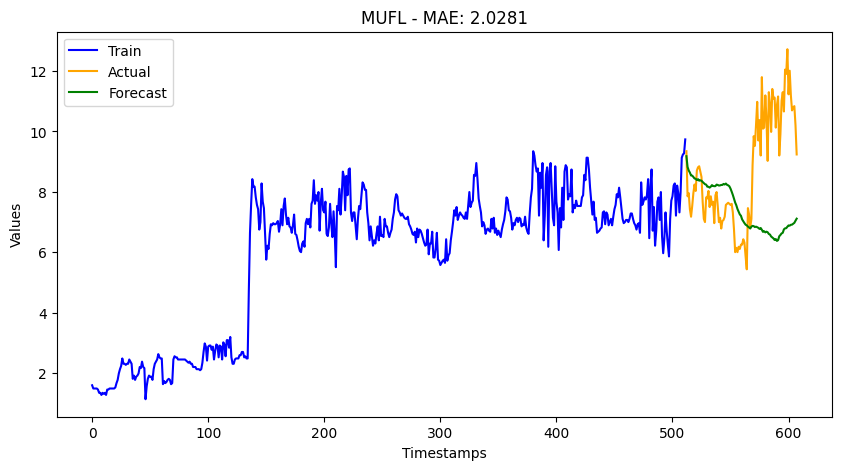

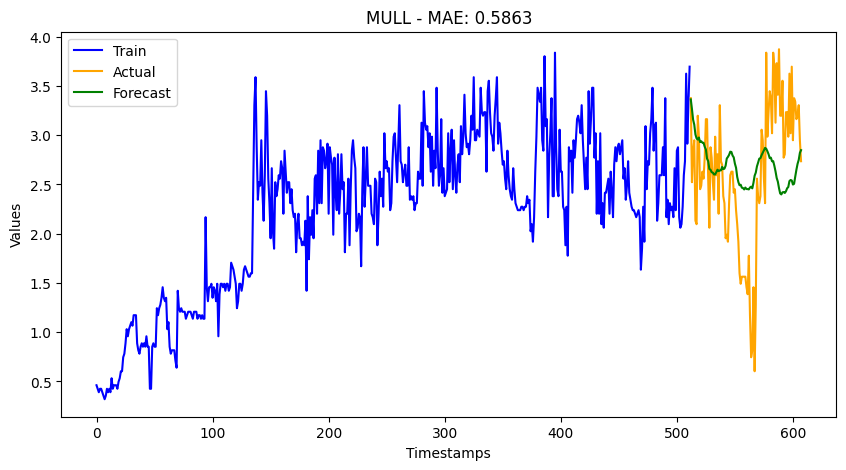

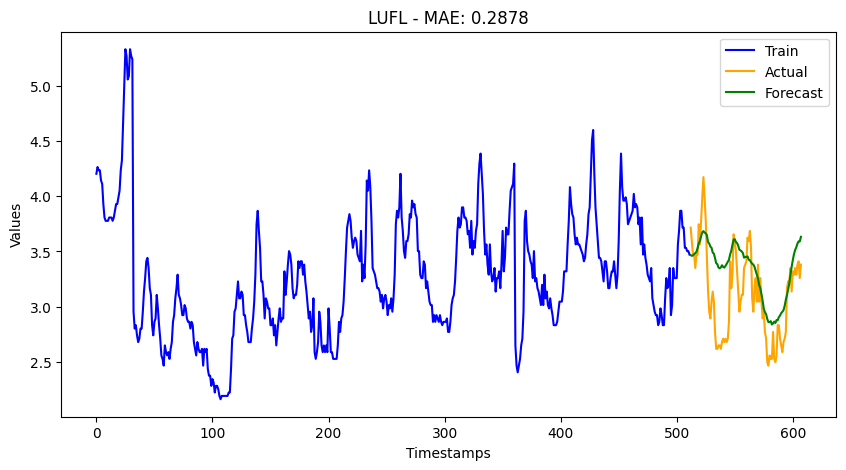

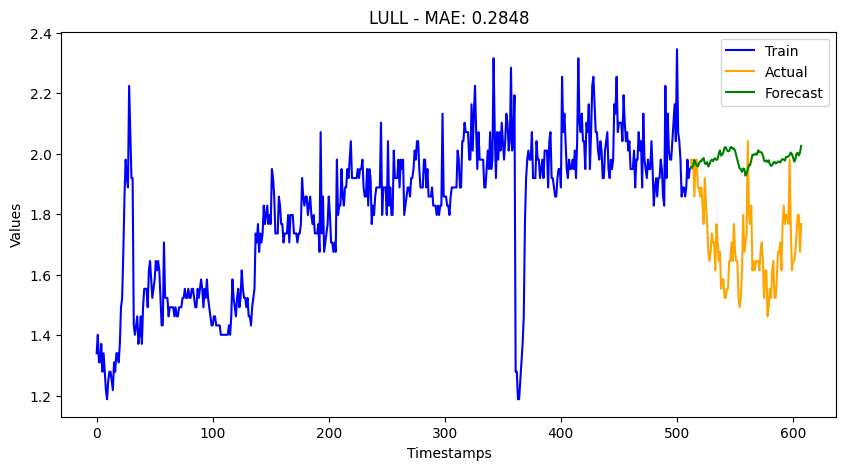

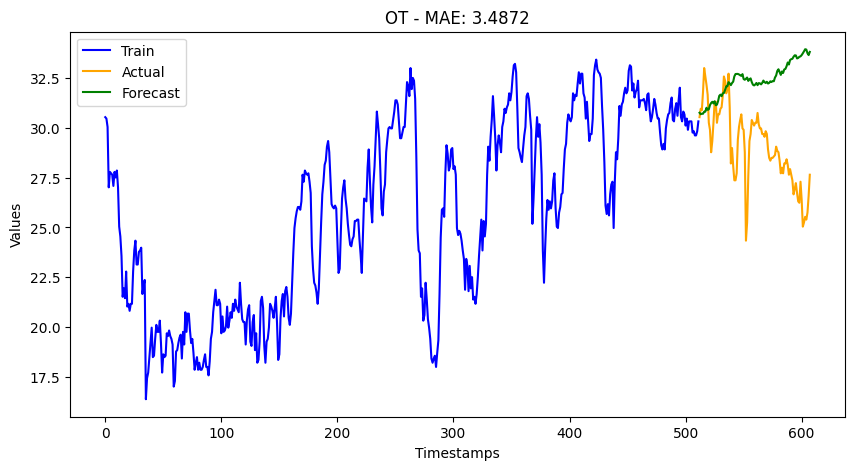

Mean Absolute Errors for each time series:
HUFL: 1.7812
HULL: 0.9280
MUFL: 2.0281
MULL: 0.5863
LUFL: 0.2878
LULL: 0.2848
OT: 3.4872


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
from sklearn.metrics import mean_absolute_error

# Load data from the specified path
data = pd.read_csv("/kaggle/input/electricity/ETTm1.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is datetime
data.set_index('date', inplace=True)  # Set 'date' as index

# Extract the first 512 + 96 values
input_length = 512
output_length = 96
total_length = input_length + output_length

subset_data = data.iloc[:total_length]

# Initialize results
mae_results = {}
predictions = {}

# TimesFm parameters (Torch backend)
tfm = TimesFm(
    hparams=TimesFmHparams(
        backend="gpu",                # Change to "cpu" if GPU is unavailable
        per_core_batch_size=32,
        horizon_len=output_length,
    ),
    checkpoint=TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    )
)

# Forecasting for each column
for column in subset_data.columns:
    ts_data = subset_data[column]
    
    # Split into input and output
    train = ts_data.iloc[:input_length].values
    true_values = ts_data.iloc[input_length:total_length].values
    
    # Prepare input for TimesFm
    train_input = np.expand_dims(train, axis=0)  # TimesFm expects batch dimension
    
    # Forecast (assumes forecast is the first element of the returned tuple)
    forecast_tuple = tfm.forecast(train_input)
    forecast = forecast_tuple[0]  # Extract the forecasted values
    
    # Flatten the forecast if needed
    forecast = forecast.flatten()
    
    # Calculate MAE
    mae = mean_absolute_error(true_values, forecast)

    mae_results[column] = mae
    predictions[column] = (true_values, forecast)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(range(input_length), train, label='Train', color='blue')
    plt.plot(range(input_length, total_length), true_values, label='Actual', color='orange')
    plt.plot(range(input_length, total_length), forecast, label='Forecast', color='green')
    plt.title(f"{column} - MAE: {mae:.4f}")
    plt.xlabel("Timestamps")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

# Display MAE for all series
print("Mean Absolute Errors for each time series:")
for col, mae in mae_results.items():
    print(f"{col}: {mae:.4f}")


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

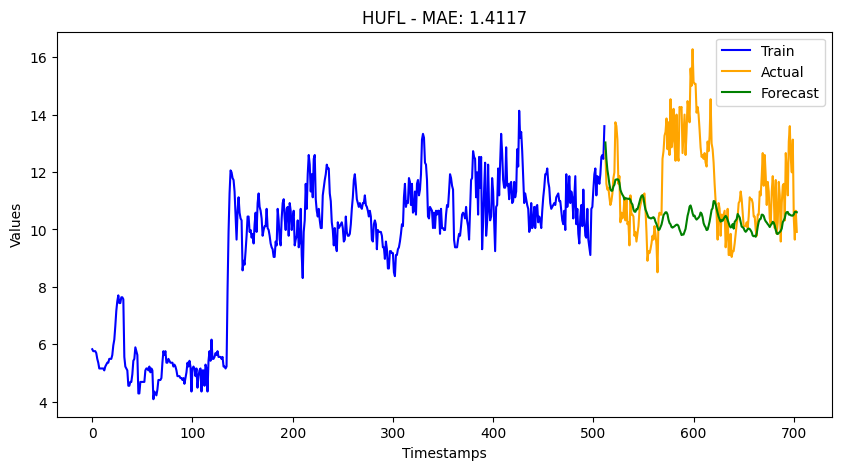

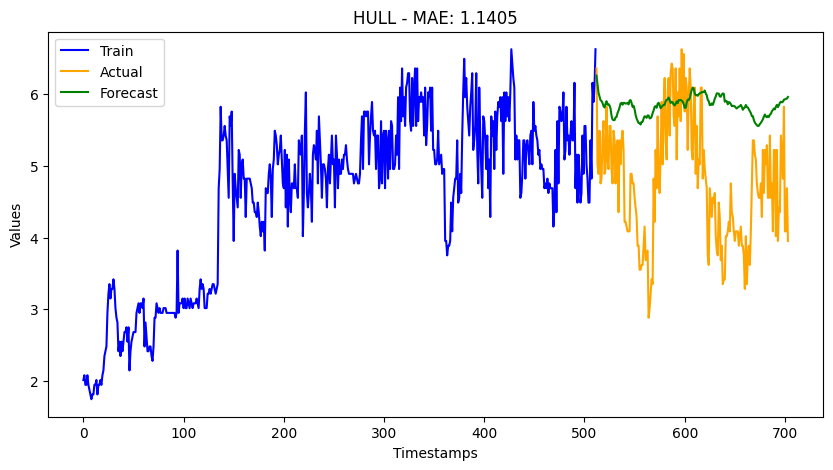

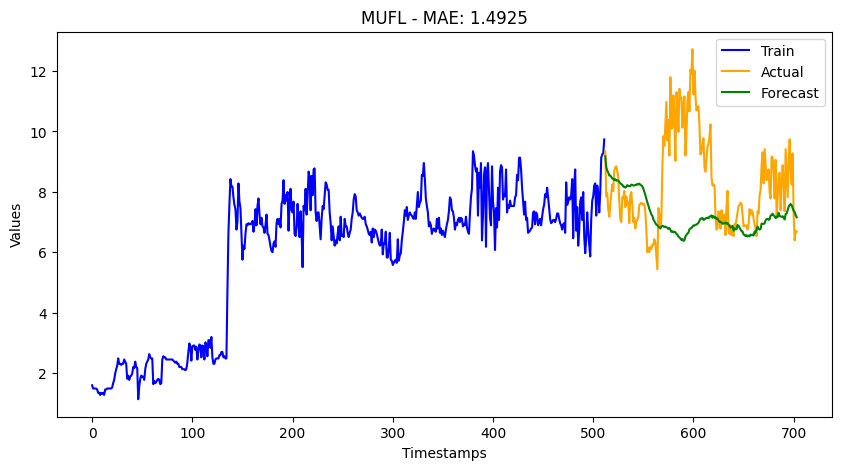

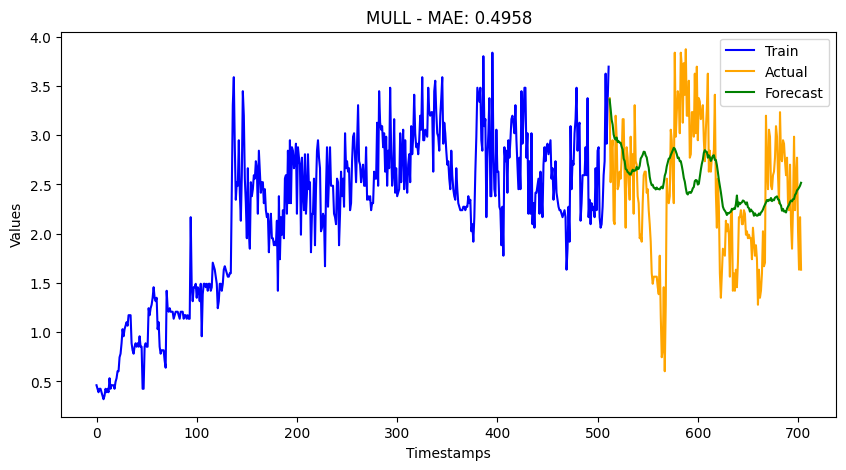

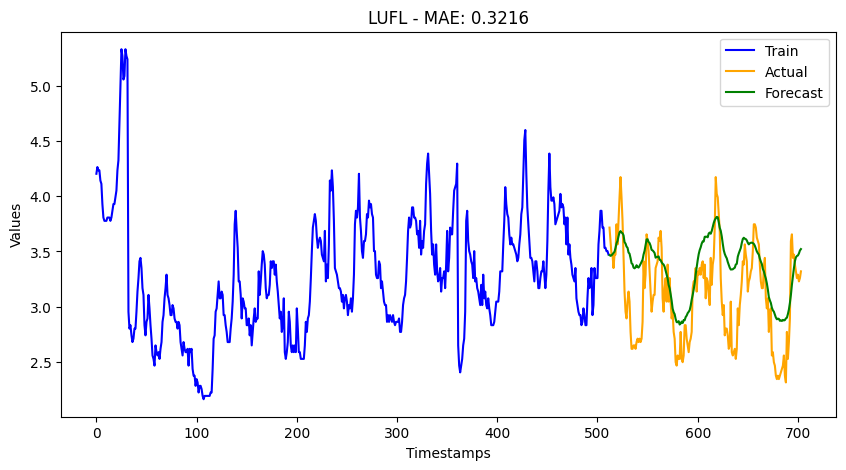

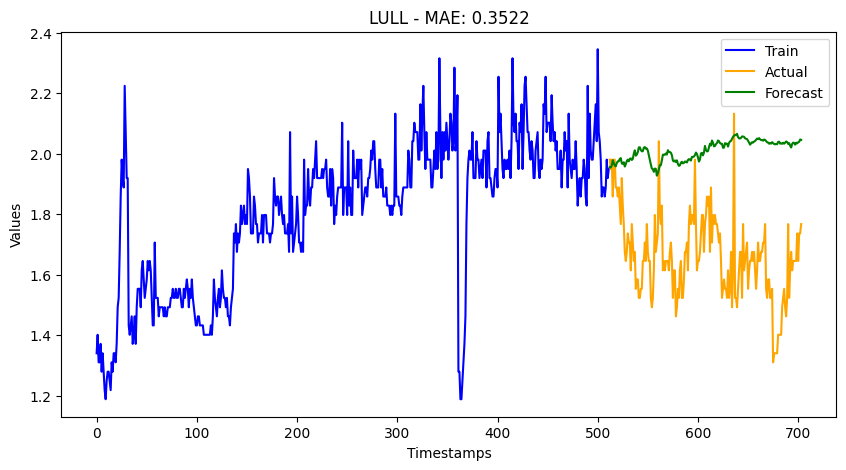

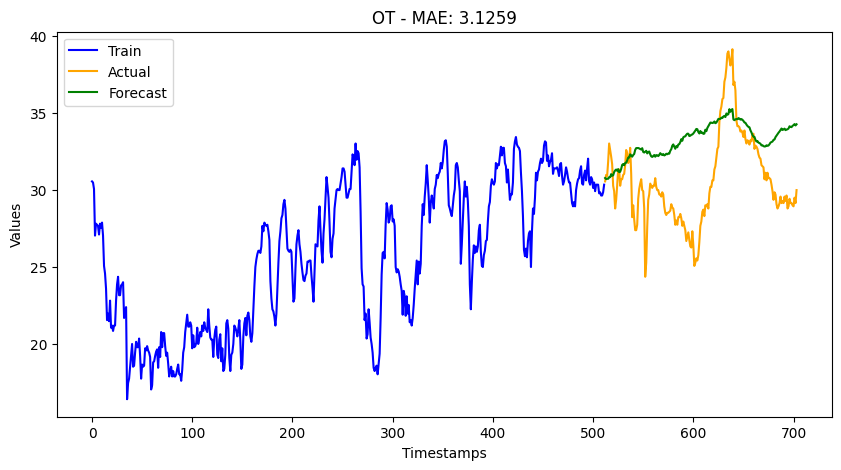

Mean Absolute Errors for each time series:
HUFL: 1.4117
HULL: 1.1405
MUFL: 1.4925
MULL: 0.4958
LUFL: 0.3216
LULL: 0.3522
OT: 3.1259


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
from sklearn.metrics import mean_absolute_error

# Load data from the specified path
data = pd.read_csv("/kaggle/input/electricity/ETTm1.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is datetime
data.set_index('date', inplace=True)  # Set 'date' as index

# Extract the first 512 + 96 values
input_length = 512
output_length = 192
total_length = input_length + output_length

subset_data = data.iloc[:total_length]

# Initialize results
mae_results = {}
predictions = {}

# TimesFm parameters (Torch backend)
tfm = TimesFm(
    hparams=TimesFmHparams(
        backend="gpu",                # Change to "cpu" if GPU is unavailable
        per_core_batch_size=32,
        horizon_len=output_length,
    ),
    checkpoint=TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    )
)

# Forecasting for each column
for column in subset_data.columns:
    ts_data = subset_data[column]
    
    # Split into input and output
    train = ts_data.iloc[:input_length].values
    true_values = ts_data.iloc[input_length:total_length].values
    
    # Prepare input for TimesFm
    train_input = np.expand_dims(train, axis=0)  # TimesFm expects batch dimension
    
    # Forecast (assumes forecast is the first element of the returned tuple)
    forecast_tuple = tfm.forecast(train_input)
    forecast = forecast_tuple[0]  # Extract the forecasted values
    
    # Flatten the forecast if needed
    forecast = forecast.flatten()
    
    # Calculate MAE
    mae = mean_absolute_error(true_values, forecast)

    mae_results[column] = mae
    predictions[column] = (true_values, forecast)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(range(input_length), train, label='Train', color='blue')
    plt.plot(range(input_length, total_length), true_values, label='Actual', color='orange')
    plt.plot(range(input_length, total_length), forecast, label='Forecast', color='green')
    plt.title(f"{column} - MAE: {mae:.4f}")
    plt.xlabel("Timestamps")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

# Display MAE for all series
print("Mean Absolute Errors for each time series:")
for col, mae in mae_results.items():
    print(f"{col}: {mae:.4f}")
